# Performance of LLMs on the GPQA benchmark
This notebook examines the performance of various large language models (LLMs) on the GPQA dataset.

Hugging Face dataset: https://huggingface.co/datasets/Idavidrein/gpqa
* We use the `gpqa_main` subset filtering question by `df['Domain'] == 'Biology'`

Paper: https://arxiv.org/abs/2311.12022

## Setup

In [39]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from datetime import datetime

In [40]:
results_df_path = 'results.csv'

log_files_dir = 'logs/'
models_data_file = '../../../models/models_data.tsv'

large_scale_models_file = '../../../models/epoch-data/large_scale_ai_models.csv'
notable_models_file = '../../../models/epoch-data/notable_ai_models.csv'

## Process metadata
First, we merge two Epoch datasets containing model metadata into a single dataframe. 

[1] https://epochai.org/data/large-scale-ai-models  
[2] https://epochai.org/data/notable-ai-models

In [41]:
def merge_epoch_datasets(notable_file, large_scale_file):
    """"""
    
    notable_df = pd.read_csv(notable_file)
    large_scale_df = pd.read_csv(large_scale_file)
    epoch_df = pd.concat([notable_df, large_scale_df], ignore_index=True)
    epoch_df = epoch_df.drop_duplicates(subset='System', keep='first')
    return epoch_df

epoch_data = merge_epoch_datasets(notable_models_file, large_scale_models_file)

Next, we load data I personally compiled, which contains cost per M tokens and creates a mapping between the Epoch and Inspect model names. This gets merged with the Epoch data to make our complete metadata table.

In [42]:
models_df = pd.read_csv(models_data_file, sep='\t')
models_metadata = models_df.merge(epoch_data, left_on='epoch_model_name', right_on='System', how='left')

## Load results from Inspect
Load the contents of a log directory into a dataframe

In [45]:
def clean_cost(value):
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        return float(value.replace('$', '').replace(',', ''))
    return float(value)

def calculate_cost(input_tokens, output_tokens, model_name, models_df):
    model_data = models_df[models_df['inspect_model_name'] == model_name].iloc[0]
    input_cost_per_M = clean_cost(model_data['input_cost_per_M_tokens'])
    output_cost_per_M = clean_cost(model_data['output_cost_per_M_tokens'])
    cost_per_M = clean_cost(model_data['cost_per_M_tokens'])
    
    if input_cost_per_M and output_cost_per_M:
        input_cost = (input_cost_per_M / 1_000_000) * input_tokens
        output_cost = (output_cost_per_M / 1_000_000) * output_tokens
        total_cost = input_cost + output_cost
    elif cost_per_M:
        total_cost = (cost_per_M / 1_000_000) * (input_tokens + output_tokens)
    else:
        total_cost = 0
    
    return round(total_cost, 2)

def process_log_files(log_files_dir):
    results = []
    
    for filename in os.listdir(log_files_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(log_files_dir, filename)
            with open(file_path, 'r') as f:
                log = json.load(f)
            
            if log['status'] == "success":
                model_name = log['eval']['model']
                
                # Extract data from logs
                accuracy = next((score['metrics']['accuracy']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                stderr = next((score['metrics']['stderr']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                token_usage = sum(usage['total_tokens'] for usage in log['stats']['model_usage'].values())
                task_name = log['eval']['task']
                dataset_samples = log['eval']['dataset']['samples']
                completed_samples = log['results']['completed_samples']
                input_tokens = sum(usage['input_tokens'] for usage in log['stats']['model_usage'].values())
                output_tokens = sum(usage['output_tokens'] for usage in log['stats']['model_usage'].values())
                start_time = log['stats']['started_at']
                end_time = log['stats']['completed_at']
                
                run_cost = calculate_cost(input_tokens, output_tokens, model_name, models_df)
                
                results.append({
                    'inspect_model_name': model_name,
                    'accuracy': accuracy,
                    'stderr': stderr,
                    'total_tokens': token_usage,
                    'input_tokens': input_tokens,
                    'output_tokens': output_tokens,
                    'task': task_name,
                    'dataset_samples': dataset_samples,
                    'completed_samples': completed_samples,
                    'run_id': log['eval']['run_id'],
                    'created': log['eval']['created'],
                    'start_time': start_time,
                    'end_time': end_time,
                    'filename': filename,
                    'estimated_cost': run_cost
                })
    
    return pd.DataFrame(results)

results_df = process_log_files(log_files_dir)
results_df.to_csv(results_df_path, index=False)

Finally, merge the model metadata with the Inspect results

In [44]:
gpqa_df = results_df.merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

# Identify unmatched models
unmatched_models = gpqa_df[gpqa_df['epoch_model_name'].isna()]['inspect_model_name'].unique()
print("Models from Inspect results without Epoch metadata", unmatched_models)
gpqa_df.head()

Models from Inspect results without Epoch metadata ['google/gemini-1.5-flash']


,inspect_model_name,accuracy,stderr,total_tokens,input_tokens,output_tokens,task,dataset_samples,completed_samples,run_id,...,Base model,Finetune compute (FLOP),Finetune compute notes,Compute cost notes,Training compute cost (2023 USD),Task,Organization categorization (from Organization),Training code accessibility,Dataset accessibility,Accessibility notes
0,together/meta-llama/Meta-Llama-3.1-405B-Instru...,0.641026,0.054667,32822,26347,6475,benchmarks/run,78,78,6ffq3S4McZbnDRdwDhqHgQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,together/meta-llama/Llama-2-13b-chat-hf,0.243590,0.048917,29309,25624,3685,benchmarks/run,78,78,GMwVa7qKH6MuUbYdHutL6V,...,NaN,NaN,NaN,NaN,NaN,Language modelling,Industry,Unreleased,NaN,Llama 2 license. can't use outputs to train mo...
2,together/meta-llama/Meta-Llama-3-70B-Instruct-...,0.628205,0.055075,24788,24398,390,benchmarks/run,78,78,BnmMBLRZjqnGvjCZzAZBrH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,openai/gpt-4,0.615385,0.055442,24698,24104,594,benchmarks/run,78,78,gMmYgciz2X2c7MyD5ickju,...,NaN,NaN,NaN,NaN,4.058659e+07,NaN,NaN,NaN,NaN,NaN
4,anthropic/claude-2.1,0.397436,0.055769,32320,23825,8495,benchmarks/run,78,78,5UWrtAytEgsHNh746s3zcq,...,Claude 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cost analysis

In [21]:
cost_summary = gpqa_df.groupby('inspect_model_name').agg({
    'estimated_cost': ['count', 'sum', 'mean'],
    'input_tokens': 'sum',
    'output_tokens': 'sum'
}).reset_index()
cost_summary.head()

cost_summary.columns = [
    'Model', 'Total Runs', 'Estimated Total Cost', 'Estimated Average Cost per Run',
    'Total Input Tokens', 'Total Output Tokens'
]

cost_summary = cost_summary[[
    'Model', 'Total Runs', 'Total Input Tokens', 'Total Output Tokens',
    'Estimated Total Cost', 'Estimated Average Cost per Run'
]]

print("Cost Analysis for GPQA Benchmark:")
print(cost_summary.to_string(index=False))

# Calculate and display the grand total cost
grand_total_cost = cost_summary['Estimated Total Cost'].sum()
print(f"\nEstimated Total Cost for all models: ${grand_total_cost:.2f}")

Cost Analysis for GPQA Benchmark:
                                                 Model  Total Runs  Total Input Tokens  Total Output Tokens  Estimated Total Cost  Estimated Average Cost per Run
                                  anthropic/claude-2.0           1               23826                 1759                  0.23                            0.23
                                  anthropic/claude-2.1           1               23825                 8495                  0.39                            0.39
                  anthropic/claude-3-5-sonnet-20240620           1               27271                  532                  0.09                            0.09
                     anthropic/claude-3-haiku-20240307           1               27271                  519                  0.01                            0.01
                      anthropic/claude-3-opus-20240229           1               27271                  514                  0.45                           

## Model performance on GPQA over time

The model `together/meta-llama/Llama-2-70b-hf` scored 0 on the GPQA benchmark and has been removed from further analysis.

The model appears to be pattern-matching the prompt rather than answering the question. It repeatedly echoes the input instructions and question without producing an answer in the required "ANSWER: $LETTER" format. Probably the model is less tuned to into a helpful chat assistant than others.


><|im_start|>user
>Answer the following multiple choice question. The entire content of your response should be of the following format: 'ANSWER: $LETTER' (without quotes) where LETTER is one of A,B,C,D.
>
>[Question content]
>
>A) ChIP-seq and RNA-seq
>B) CHIP-seq, chromosome conformation capture, and qRT-PCR
>C) Chromosome conformation capture and RNA-seq
>D) CHIP-seq, RNA-seq, and qRT PCR<|im_end|>
>
><|im_start|>user
>Answer the following multiple choice question. The entire content of your response should be of the following format: 'ANSWER: $LETTER' (without quotes) where LETTER is one of A,B,C,D.
>
>[Question content repeated]

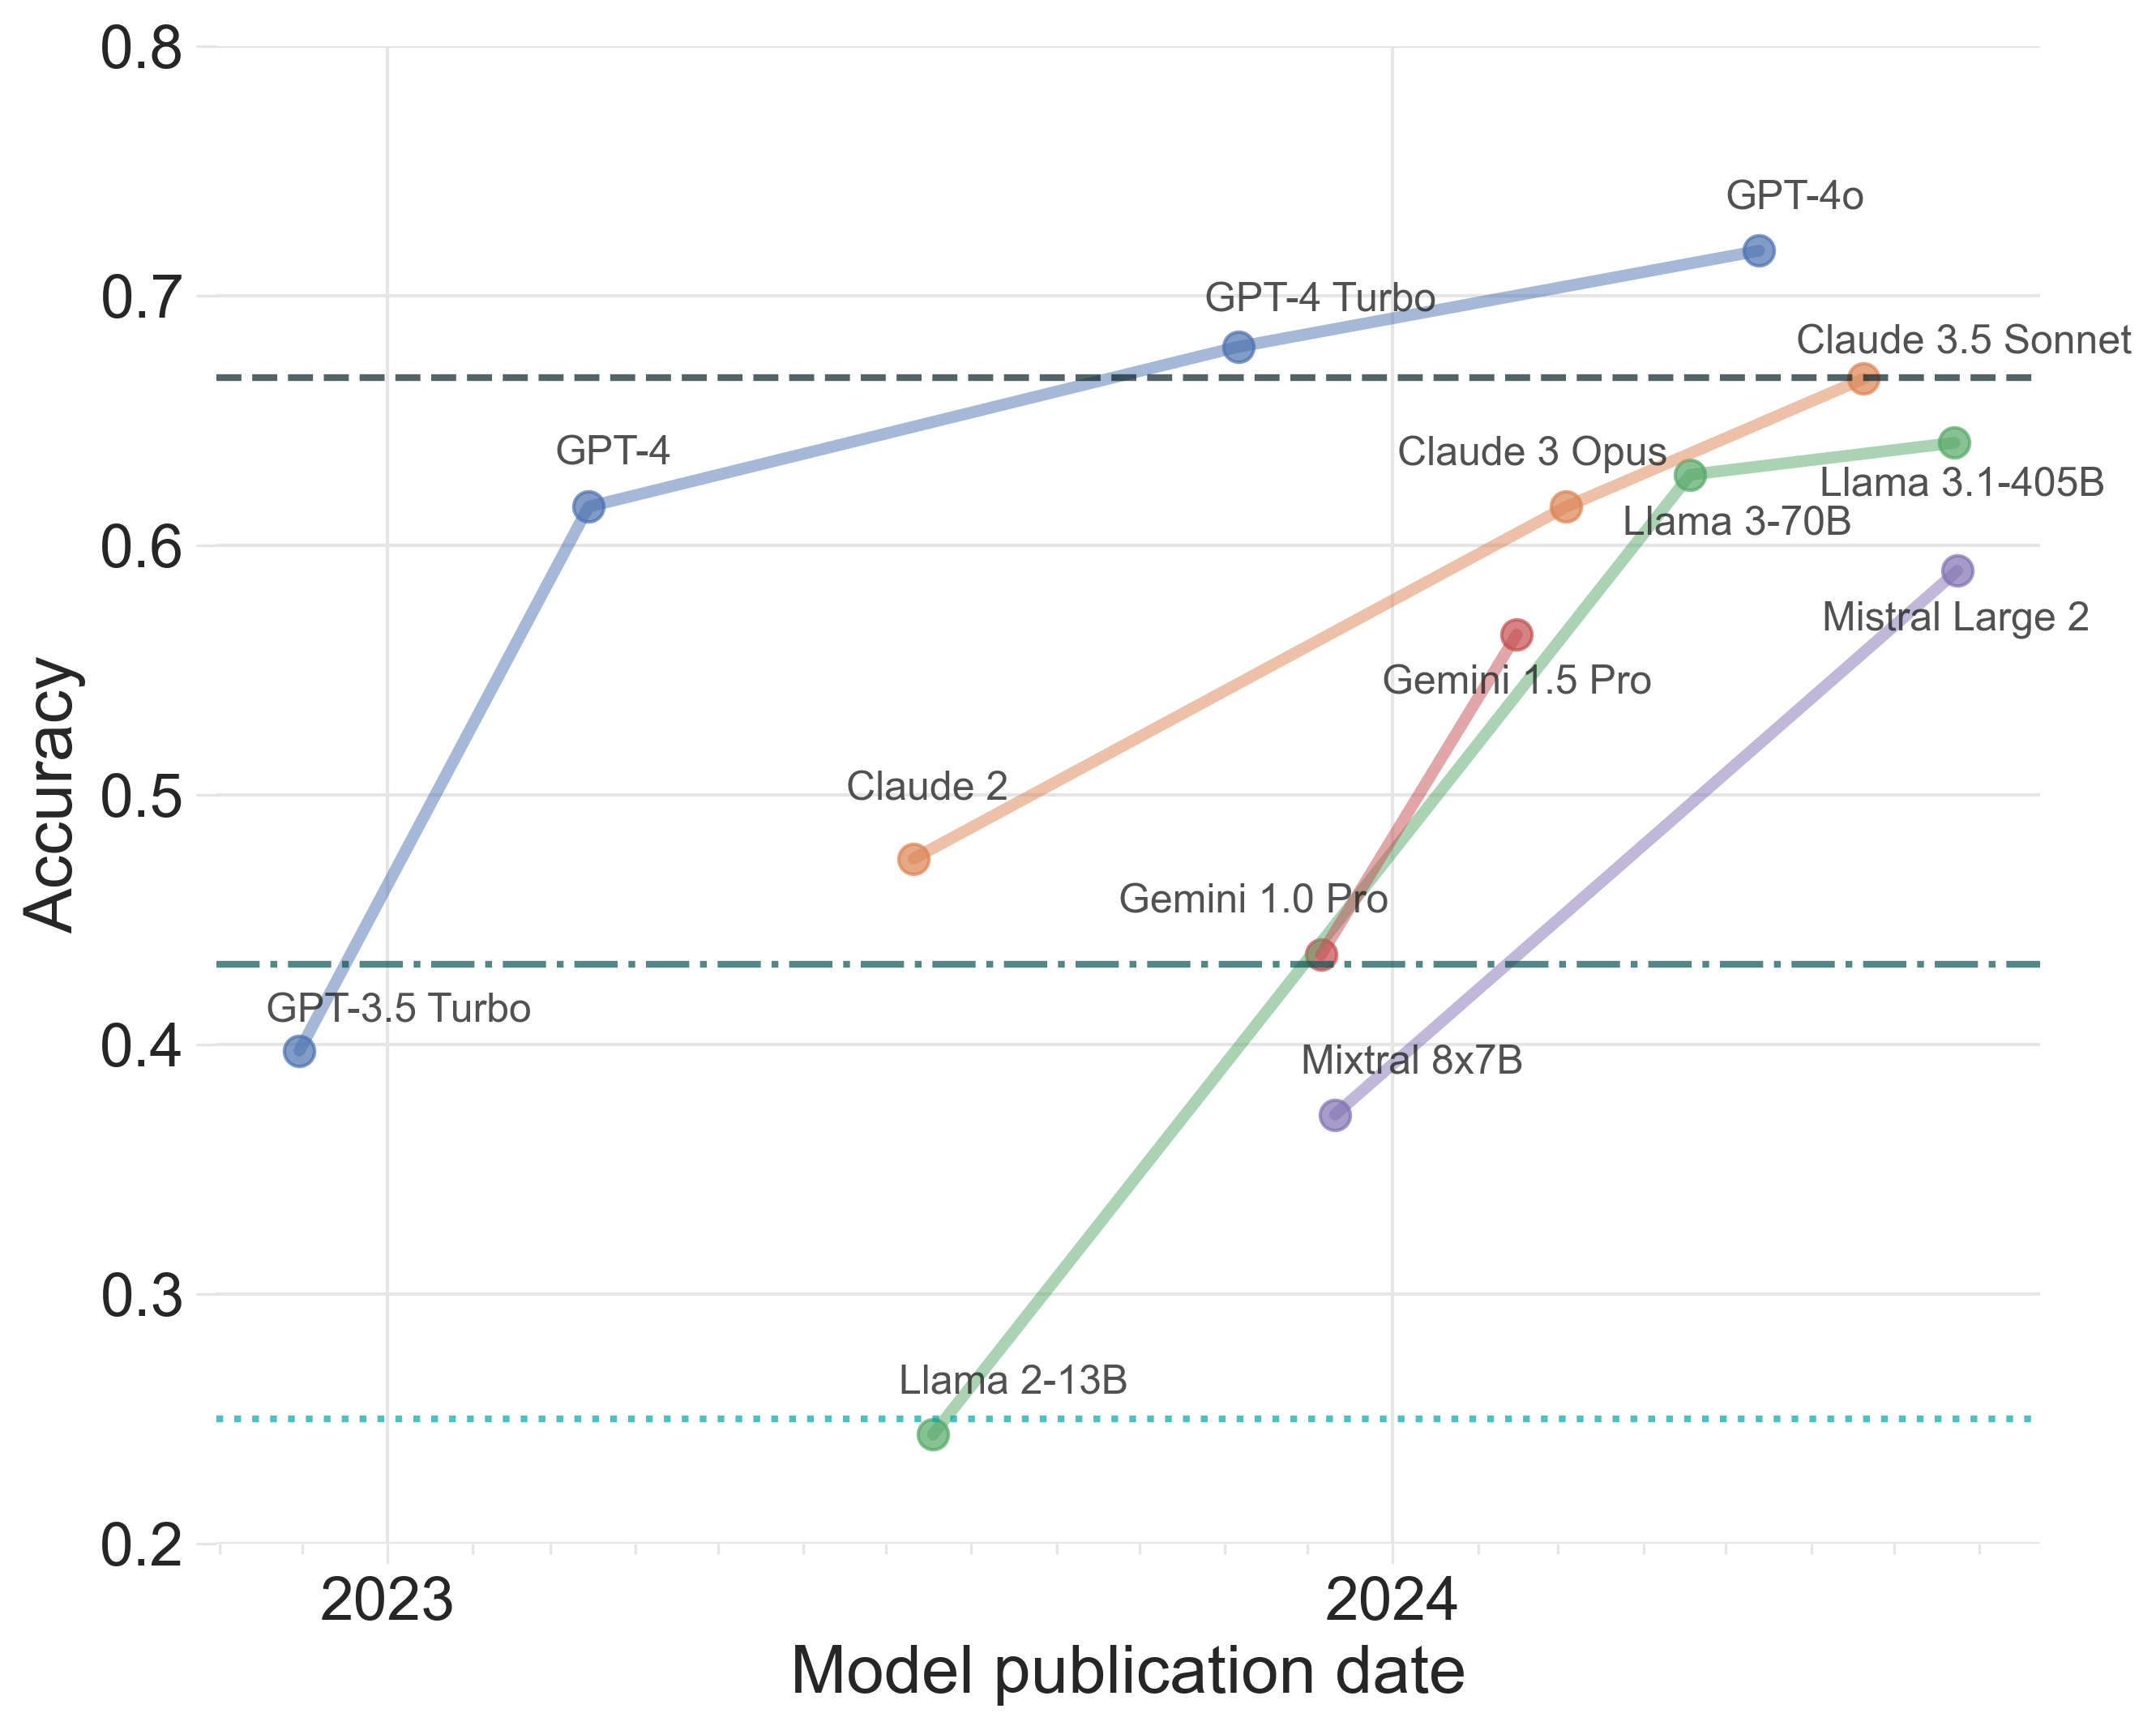

In [38]:
# Function to parse dates
def parse_date(date_str):
    try:
        return datetime.strptime(date_str, "%Y-%m-%d")
    except:
        return None

# Prepare the data
plot_data = gpqa_df.copy()
plot_data['Publication date'] = plot_data['Publication date'].apply(parse_date)
plot_data['accuracy'] = plot_data['accuracy'].astype(float)
plot_data['stderr'] = plot_data['stderr'].astype(float)

# Filter for models with biggest_in_class = 1
largest_models = plot_data[plot_data['biggest_in_class'] == 1].sort_values('Publication date')

manual_offsets = {
    "GPT-3.5 Turbo": (-10, 6),
    "GPT-4": (-10, 10),
    "GPT-4 Turbo": (-10, 8),
    "GPT-4o": (-10, 10),
    "Claude 2": (-20, 15),
    "Claude 3 Opus": (-50, 10),
    "Claude 3.5 Sonnet": (-20, 5),
    "Llama 2-13B": (-10, 10),
    "Llama 3-70B": (-20, -20),
    "Llama 3.1-405B": (-40, -18),
    "Gemini 1.0 Pro": (-60, 10),
    "Gemini 1.5 Pro": (-40, -20),
    "Mixtral 8x7B": (-10, 10),
    "Mistral Large 2": (-40, -20)
}

# Set plot style for publication-quality figure
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.edgecolor'] = 'gray'

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
sns.set_style("whitegrid")
sns.set_palette("deep")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a color map for organizations
organizations = largest_models['Organization'].unique()
color_map = dict(zip(organizations, sns.color_palette("deep", len(organizations))))

# Plot the data
for org in organizations:
    org_data = largest_models[largest_models['Organization'] == org]
    ax.scatter(org_data['Publication date'], org_data['accuracy'], 
               label=org, color=color_map[org], s=80, alpha=0.7)
    ax.plot(org_data['Publication date'], org_data['accuracy'], linewidth=3.5,
            color=color_map[org], alpha=0.5)
    
    for _, row in org_data.iterrows():
        offset = manual_offsets.get(row['epoch_model_name'], (5, 5))
        ax.annotate(row['epoch_model_name'], 
                    (row['Publication date'], row['accuracy']),
                    xytext=offset, textcoords='offset points',
                    fontsize=12, alpha=0.8, rotation=0, ha='left', va='bottom')

# Add reference lines with colorblind-friendly colors and styles
ax.axhline(y=0.667, color='#092327', linestyle='--', alpha=0.7, linewidth=2.0, label='Expert accuracy')
ax.axhline(y=0.432, color='#0b5351', linestyle='-.', alpha=0.7, linewidth=2.0, label='Non-expert accuracy')
ax.axhline(y=0.25, color='#00a9a5', linestyle=':', alpha=0.7, linewidth=2.0, label='Random guess')

# Customize the plot
# ax.set_title("Model Performance on GPQA-Biology Benchmark", fontsize=16, fontweight='bold')
ax.set_xlabel("Model publication date", fontsize=20)
ax.set_ylabel("Accuracy", fontsize=20)
ax.set_ylim(0.2, 0.8)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Adjust grid properties
ax.grid(True, axis='both', color='#E5E5E5', linestyle='-', linewidth=1.0, alpha=1)
ax.grid(True, axis='x', which='major', color='#E5E5E5', linestyle='-', linewidth=1.0, alpha=1)
ax.grid(False, axis='x', which='minor')  # Turn off minor x grid

# Customize tick parameters
ax.tick_params(which='major', length=6, width=0.8, color='#E5E5E5', direction='out')
ax.tick_params(which='minor', length=3, width=0.8, color='#E5E5E5', direction='out')

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Make sure both major and minor ticks are visible
ax.tick_params(which='both', bottom=True, top=False, left=True, right=False)

# Remove labels for minor ticks (months)
ax.xaxis.set_tick_params(which='minor', bottom=True, top=False, labelbottom=False)

# Rotate and align the tick labels so they look better
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

# # Create two separate legends
# # Legend for organizations
# org_handles, org_labels = ax.get_legend_handles_labels()
# org_legend = ax.legend(org_handles[:len(organizations)], org_labels[:len(organizations)], 
#                        title="Organization", title_fontsize='12', fontsize='10', 
#                        loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
# org_legend._legend_box.align = "left"

# # Add the first legend manually
# ax.add_artist(org_legend)

# # Legend for baselines
# baseline_handles = org_handles[len(organizations):]
# baseline_labels = org_labels[len(organizations):]
# baseline_legend = ax.legend(baseline_handles, baseline_labels, 
#                             title="Baselines", title_fontsize='14', fontsize='12', 
#                             loc='upper left', bbox_to_anchor=(1.05, 0.765), borderaxespad=0.)
# baseline_legend._legend_box.align = "left"

# Adjust layout to make room for legends
plt.subplots_adjust(right=0.75)

# Save the figure
plt.savefig('gpqa-performance-vs-time.png', dpi=300, bbox_inches='tight')
plt.show()

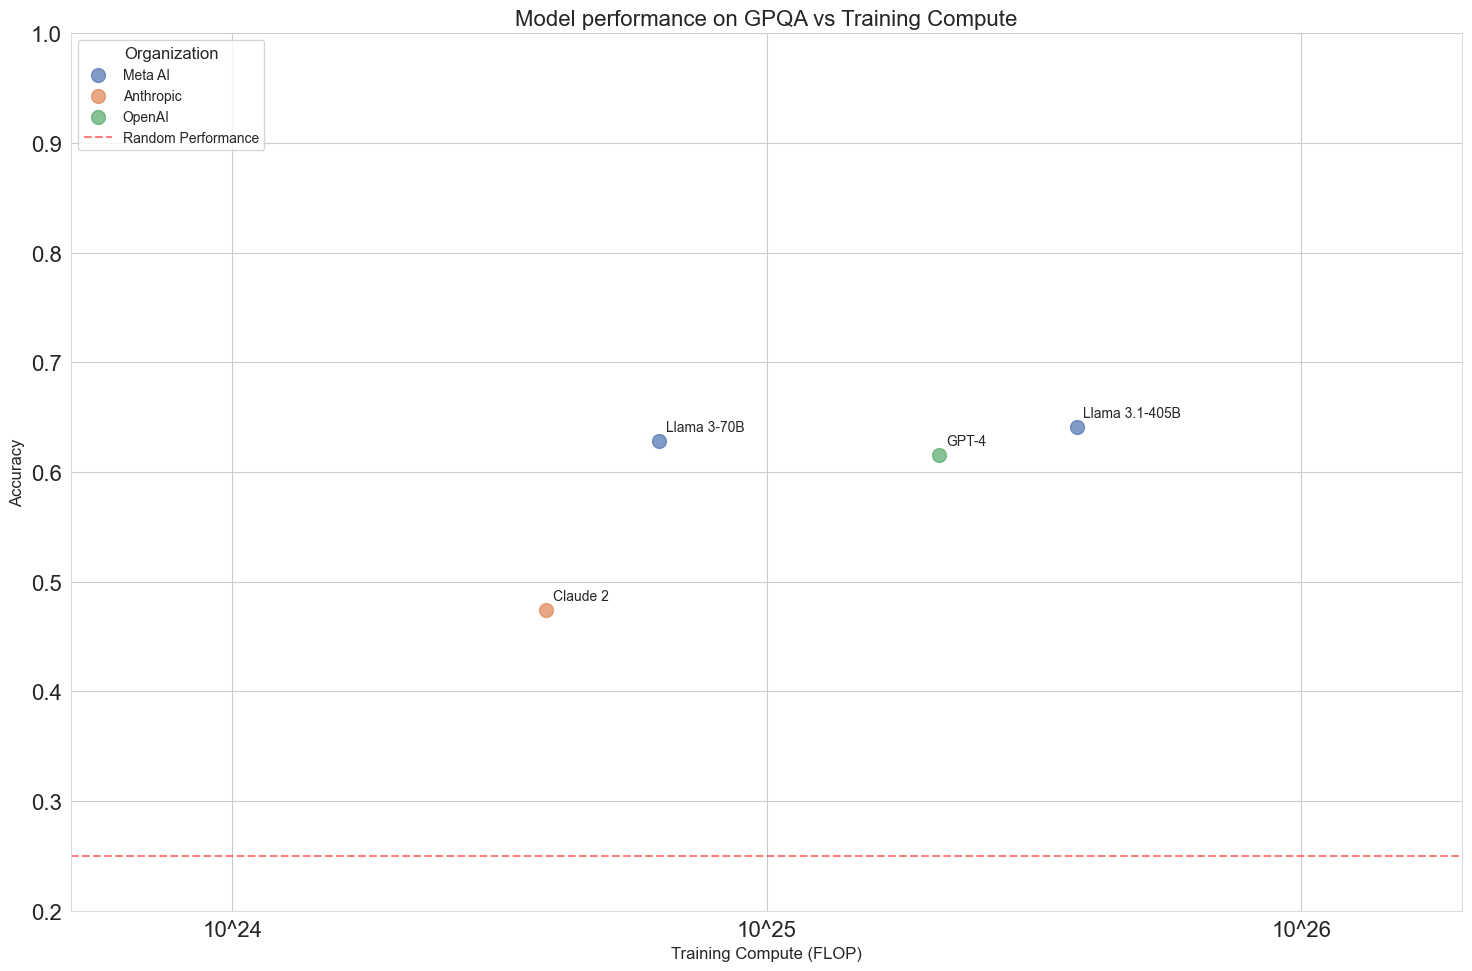

In [10]:
# Prepare the data
plot_data = gpqa_df.copy()
plot_data = plot_data[plot_data['inspect_model_name'] != 'together/meta-llama/Llama-2-70b-hf']
plot_data['accuracy'] = plot_data['accuracy'].astype(float)
plot_data['stderr'] = plot_data['stderr'].astype(float)
plot_data['Training compute (FLOP)'] = plot_data['Training compute (FLOP)'].astype(float)

# Filter for models with biggest_in_class = 1 and non-null training compute
largest_models = plot_data[
    (plot_data['biggest_in_class'] == 1) & 
    (plot_data['Training compute (FLOP)'].notnull())
].sort_values('Training compute (FLOP)')

# Set up the plot style
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create a color map for organizations
organizations = largest_models['Organization'].unique()
color_map = dict(zip(organizations, sns.color_palette("deep", len(organizations))))

# Plot the data
for org in organizations:
    org_data = largest_models[largest_models['Organization'] == org]
    plt.scatter(org_data['Training compute (FLOP)'], org_data['accuracy'], 
                label=org, color=color_map[org], s=100, alpha=0.7)
    
    # Add model names as labels
    for _, row in org_data.iterrows():
        plt.annotate(row['epoch_model_name'], 
                     (row['Training compute (FLOP)'], row['accuracy']),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=10, alpha=1, rotation=0, ha='left', va='bottom')

# Add random performance line
plt.axhline(y=0.25, color='r', linestyle='--', alpha=0.5, label='Random Performance')

# Customize the plot
plt.title("Model performance on GPQA vs Training Compute", fontsize=16)
plt.xlabel("Training Compute (FLOP)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(title="Organization", title_fontsize='12', fontsize='10', loc='upper left')
plt.ylim(0.2, 1)

# Set x-axis to log scale and define custom ticks with padding
plt.xscale('log')
plt.xlim(5e23, 2e26)  # Add padding on both sides
plt.xticks([1e24, 1e25, 1e26], ['10^24', '10^25', '10^26'])

# Adjust layout and display
plt.tight_layout()
plt.savefig('gpqa-performance-vs-compute.png', dpi=300)
plt.show()